Первые 5 строк датасета:
  Random       ACHP        PHR     AWWGV         ALAP      ANPL        ARD  \
0     R1  34.533468  54.566983  1.147449  1284.229549  4.999713  16.274918   
1     R1  34.489028  54.567692  1.149530  1284.247744  5.024259  16.269452   
2     R2  33.100405  67.067344  1.104647  1009.208996  5.007652  15.980760   
3     R1  34.498319  54.559049  1.137759  1284.227623  4.991501  16.276710   
4     R3  36.297008  45.588894  1.363205   981.470310  4.003682  16.979894   

       ADWR      PDMVG        ARL      AWWR      ADWV      PDMRG Class  
0  1.706810  18.399982  19.739037  2.949240  0.209251  57.633906    SA  
1  1.700930  18.398289  19.758836  2.943137  0.216154  57.633697    SA  
2  1.185391  19.398789  20.840822  2.861635  0.200113  41.289875    SA  
3  1.716396  18.413613  19.736098  2.946784  0.223092  57.645661    SA  
4  0.777428  31.423772  17.331894  2.766242  0.424172  27.898619    SA  

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeI

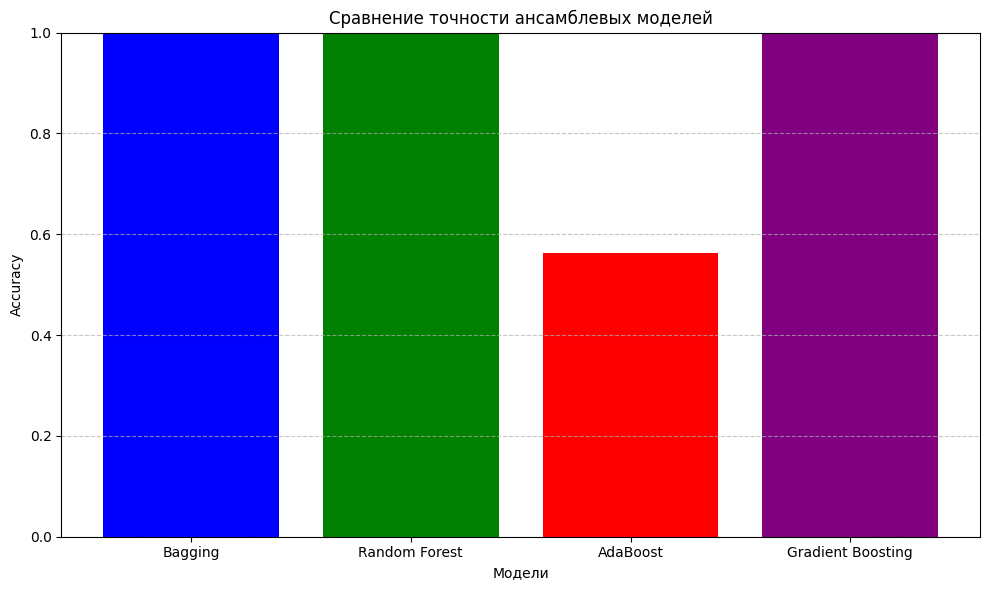

График важности признаков сохранен как 'feature_importance.png'


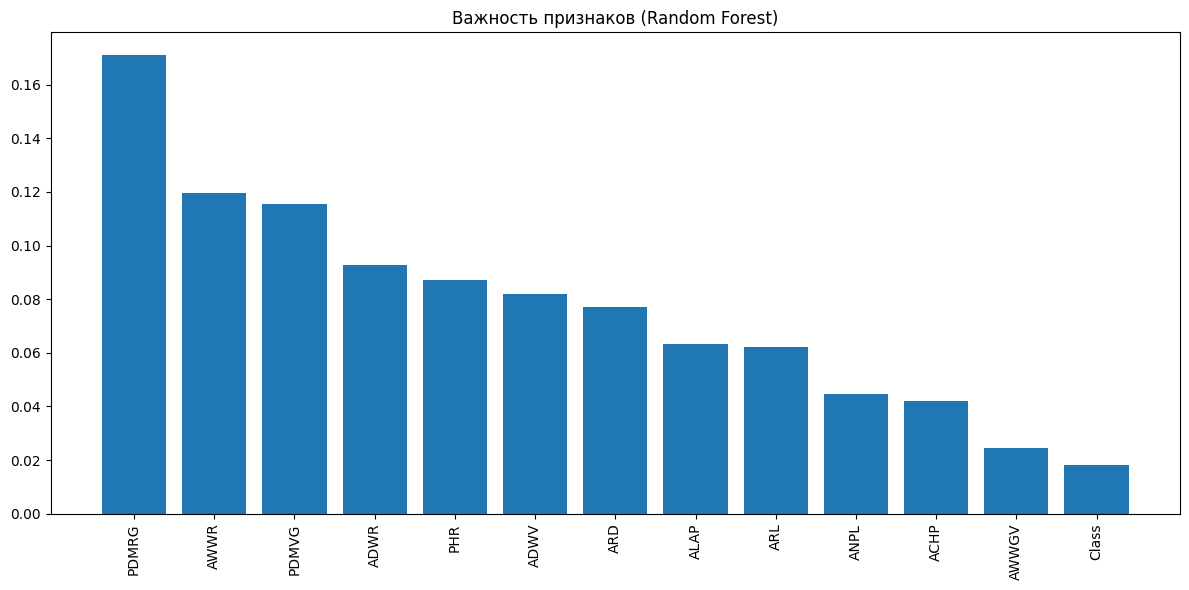

In [3]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    BaggingClassifier, 
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1. Загрузка данных
df = pd.read_csv('Greenhouse Plant Growth Metrics.csv')
print("Первые 5 строк датасета:")
print(df.head())
print("\nИнформация о датасете:")
print(df.info())

# 2. Автоматическое определение целевой переменной
# Ищем категориальные столбцы с небольшим количеством уникальных значений
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) == 0:
    # Если категориальных столбцов нет, создаем искусственную целевую переменную
    print("\nКатегориальных столбцов не найдено. Создаю искусственную целевую переменную...")
    df['target'] = pd.qcut(df.iloc[:, 0], q=3, labels=['low', 'medium', 'high'])
    target_column = 'target'
else:
    # Выбираем столбец с наименьшим количеством уникальных значений (но больше 1)
    unique_counts = df[categorical_cols].nunique()
    suitable_cols = unique_counts[(unique_counts > 1) & (unique_counts <= 10)]
    
    if len(suitable_cols) > 0:
        target_column = suitable_cols.idxmin()
        print(f"\nАвтоматически выбрана целевая переменная: '{target_column}'")
    else:
        # Если подходящих столбцов нет, создаем искусственную целевую переменную
        print("\nПодходящих категориальных столбцов не найдено. Создаю искусственную целевую переменную...")
        df['target'] = pd.qcut(df.iloc[:, 0], q=3, labels=['low', 'medium', 'high'])
        target_column = 'target'

print(f"Используется целевая переменная: {target_column}")
print(f"Уникальные значения: {df[target_column].unique()}")

# 3. Предобработка данных
# Заполнение пропусков средним значением для числовых признаков
imputer = SimpleImputer(strategy='mean')
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Кодирование категориальных признаков (кроме целевой переменной)
le = LabelEncoder()
for col in df.select_dtypes(include=['object', 'category']).columns:
    if col != target_column:
        df[col] = le.fit_transform(df[col])

# Кодирование целевой переменной
y = le.fit_transform(df[target_column])
X = df.drop(target_column, axis=1)

# 4. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\nРазмеры выборок:\nОбучающая: {X_train.shape}\nТестовая: {X_test.shape}")

# 5. Обучение ансамблевых моделей
models = {
    "Bagging": BaggingClassifier(n_estimators=50, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, random_state=42)
}

results = {}
print("\nОбучение моделей...")
for name, model in models.items():
    print(f"- Обучение {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"\n{name} - Отчет по классификации:")
    print(classification_report(y_test, y_pred))

# 6. Сравнение моделей
print("\nСравнение точности моделей:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red', 'purple'])
plt.title('Сравнение точности ансамблевых моделей')
plt.xlabel('Модели')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('models_comparison.png')
print("\nГрафик сравнения сохранен как 'models_comparison.png'")
plt.show()

# Дополнительно: важность признаков для Random Forest
if "Random Forest" in models:
    plt.figure(figsize=(12, 6))
    importances = models["Random Forest"].feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.title("Важность признаков (Random Forest)")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("График важности признаков сохранен как 'feature_importance.png'")
    plt.show()